In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage,signal
import math

In [2]:
def fftnshift(img):
    f_img = np.fft.fft2(img)
    # Hàm fftshift đưa DC component về điểm chính giữa.
    fshift = np.fft.fftshift(f_img)
    return fshift

def invert_shiftnfft(filter_fshift):
    # Invert fftshift
    filter_fishift = np.fft.ifftshift(filter_fshift)
    # Invert FFT
    filter_img = np.fft.ifft2(filter_fishift)
    return np.abs(filter_img)

def apply_fft(img, kernel):
    # Đọc hiểu code từ https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_transforms/py_fourier_transform/py_fourier_transform.html

    # Sử dụng hàm fft2 cho ảnh 2 chiều, output là biểu diễn tần số của input,
    # giá trị ở mỗi điểm ảnh là 1 số phức biểu diễn magnitude và phase,
    # zero frequency component (hay DC component) sẽ ở góc trái trên.
    f_img = np.fft.fft2(img)

    # Hàm fftshift đưa DC component về điểm chính giữa.
    fshift = np.fft.fftshift(f_img)
    filter_fshift = fshift*kernel 
    # Invert fftshift
    filter_fishift = np.fft.ifftshift(filter_fshift)
    # Invert FFT
    filter_img = np.fft.ifft2(filter_fishift)
    return np.abs(filter_img)

In [3]:
def showgray(img):
    fig, ax = plt.subplots()
    ax.imshow(img, cmap='gray')
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

def show(img):
    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()
    
def plotmxn(m, n, data, is_image, labels=None,  size=(10, 10)):
    if size:
        plt.figure(figsize=size)
    for i in range(len(data)):
        ax = plt.subplot(m,n,i+1)
    #     plt.grid(False)
        if is_image:
            plt.imshow(data[i])
        else:
            plt.plot(data[i][0], data[i][1])
        if labels:
            plt.xlabel(labels[i])
    plt.show()

In [4]:
# Các hàm sinh filter
def idea_lowpass_filter(shape, r):
    tmp = np.zeros(shape)
    center = np.array(shape) // 2
    I, J = np.ogrid[:shape[0], :shape[1]]
    return (I - center[0])**2 + (J - center[1])**2 < r**2

def butterworth_filter(shape, D0, n):
    center = np.array(shape) // 2
    I, J = np.ogrid[:shape[0], :shape[1]]
    D_uv = np.sqrt((I - center[0])**2 + (J - center[1])**2)
    return 1 / (1 + (D_uv/D0)**n)

def gaussian_filter(shape, D0):
    center = np.array(shape) // 2
    I, J = np.ogrid[:shape[0], :shape[1]]
    D_uv_sq = (I - center[0])**2 + (J - center[1])**2
    return np.exp(-D_uv_sq/(2*(D0**2)))/(2*D0**2*math.pi)

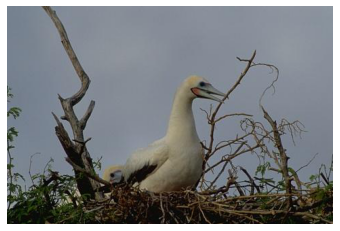

In [131]:

img = cv2.imread('mtest.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
show(img)

# Remove high-frequency noise and suppress the blur

Before calculating spectrum contrast, a Gaussian filter
with small kernel is applied to the original image to re-
move high-frequency noise and suppress the blur caused
by blur texture (e.g., soft shadows or blur patterns). The
Gaussian filter is given by
set the Gaussian kernel $σ_1$ to 0.5 in our experiment.

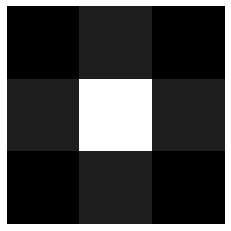

In [132]:
sigma1 = 0.5
pregf = gaussian_filter((3,3), sigma1)
pregf = np.repeat(pregf[..., None],3,axis=2)
showgray(pregf[...,2])

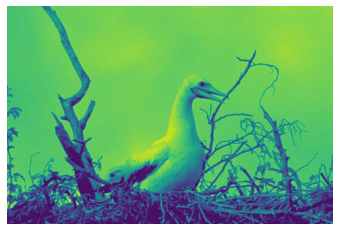

In [133]:
preimg = np.empty(img.shape)
preimg[..., 0] = ndimage.convolve(img[..., 0], pregf[..., 0], mode='nearest')
preimg[..., 1] = ndimage.convolve(img[..., 1], pregf[..., 0], mode='nearest')
preimg[..., 2] = ndimage.convolve(img[..., 2], pregf[..., 0], mode='nearest')
preimg = cv2.cvtColor(np.uint8(preimg), cv2.COLOR_RGB2GRAY)

show(preimg/255);

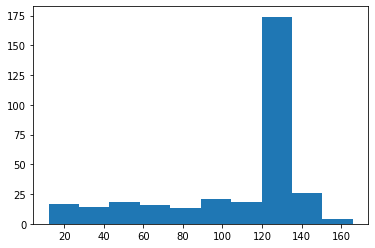

In [134]:
plt.hist(preimg[..., 2].flat);

Note that we only calculate the spectrum contrast at edge locations, we use Canny edge detector [13]to
perform our edge detection on the input image. According to the refraction regularity, chromatic aberrations are
caused by the refractive index of the lens being wave-length-dependent. This causes that color channels of
an RGB color image will appear shifted. More detailed discussion of these artif acts can be found in the paper
by Kang [14]. One can convert the image to gray scale for edge detection but it is not accurate. In order to re-
duce the error of edge detection, we perform edge detection on each color channel independently and only keep
edges that are detected within five pixels of each other in channel R, G, and B.

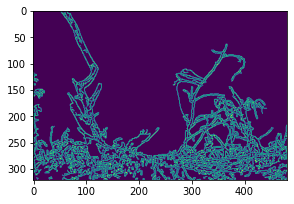

In [135]:
edges = np.empty(preimg.shape)
edges = cv2.Canny(np.uint8(preimg),80,180)
# edges[..., 1] = cv2.Canny(np.uint8(preimg[...,1]),100,180)
# edges[..., 2] = cv2.Canny(np.uint8(preimg[...,2]),100,180)
# plotmxn(2, 2, np.transpose(edges, axes=[2, 0, 1]), True)
plotmxn(2, 2, [edges,], True)

# In the Fourier domain

In [136]:
F = fftnshift(preimg)
#  = fftnshift(preimg)
N = 3
kernel = np.ones((N, N))
kernel = -kernel/(N*N-1)
kernel[N//2, N//2] = 1
print(kernel)
C = np.empty(F.shape)
c = np.empty(F.shape)
# for i in range(F.shape[-1]):
#     logi = np.log(np.abs(F[..., i]))
#     C[..., i] = np.abs(logi - signal.convolve2d(logi, kernel, mode='same')
#     c[..., i] = invert_shiftnfft(C[...,i])
logi = np.log(np.abs(F))
C = np.abs(signal.convolve2d(logi, kernel, mode='same'))
c = invert_shiftnfft(C)
sigma = 1/np.sqrt(np.exp(c) - sigma1**2)

[[-0.125 -0.125 -0.125]
 [-0.125  1.    -0.125]
 [-0.125 -0.125 -0.125]]


Giá trị lớn nhất: 17625288.999999996
Giá trị nhỏ nhất: 3.9163939341084455


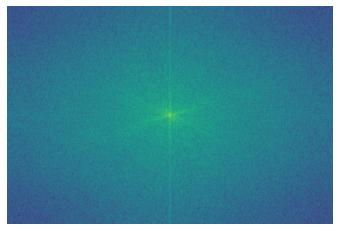

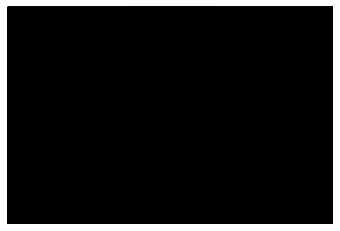

In [137]:

# Dùng np.aps để thu được magnitude
magnitude_spectrum = np.abs(F)
print("Giá trị lớn nhất:", np.max(magnitude_spectrum))
print("Giá trị nhỏ nhất:", np.min(magnitude_spectrum))

# Do giá trị lớn nhất và nhỏ nhất cách nhau lớn: 34715021.0 - 7.57761499, 
# dùng hàm log để thu hẹp khoảng này và nhân thêm 20 để tăng contrast
magnitude_spectrum = 20*np.log(magnitude_spectrum)
show(magnitude_spectrum/255)
showgray(c)

In [138]:
c

array([[5.21233281e-01, 4.77464287e-03, 1.06183557e-02, ...,
        4.73976485e-03, 1.06183557e-02, 4.77464287e-03],
       [1.15978093e-02, 2.56909975e-03, 6.20164284e-04, ...,
        8.57796549e-05, 5.53040889e-04, 1.53114095e-03],
       [1.04188281e-02, 2.12617574e-03, 7.89426060e-04, ...,
        1.93852273e-03, 1.72737251e-03, 2.61807916e-03],
       ...,
       [1.46028040e-02, 1.57928876e-03, 2.88172807e-03, ...,
        5.70989098e-05, 1.78342706e-03, 9.74585434e-04],
       [1.04188281e-02, 2.61807916e-03, 1.72737251e-03, ...,
        9.55366440e-04, 7.89426060e-04, 2.12617574e-03],
       [1.15978093e-02, 1.53114095e-03, 5.53040889e-04, ...,
        2.58601169e-03, 6.20164284e-04, 2.56909975e-03]])

In [139]:
sparse = sigma.copy()
sparse[edges == 0] = 0

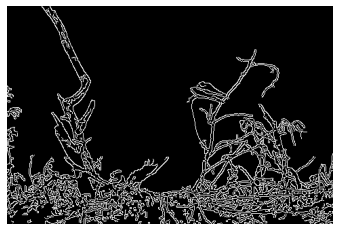

In [140]:
# s = cv2.cvtColor(sparse, cv2.COLOR_RGB2GRAY)
showgray(sparse)

(array([138434.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  15967.]),
 array([0.        , 0.11547004, 0.23094009, 0.34641013, 0.46188018,
        0.57735022, 0.69282027, 0.80829031, 0.92376035, 1.0392304 ,
        1.15470044]),
 <BarContainer object of 10 artists>)

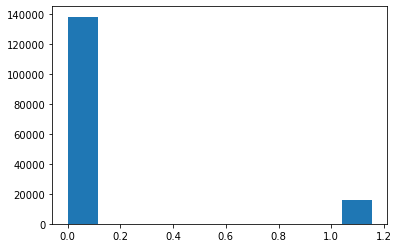

In [141]:
plt.hist(sparse.flat)

In [142]:
# !conda install -y scikit-learn

In [143]:
import mattinglaplacian
from sklearn.preprocessing import normalize
import importlib

In [144]:
importlib.reload(mattinglaplacian)
mL = mattinglaplacian.matting_laplacian

In [145]:
nsparse.shape

(216, 146)

In [146]:
# nsparse = (sparse[..., 2] - sparse[..., 2].min())/sparse[..., 2].max()
nsparse = (sparse - sparse.min())/(sparse.max() - sparse.min())
nimg = preimg/255
# nimg[..., 0] = normalize(preimg[...,0])
# nimg[..., 1] = normalize(preimg[...,1])
# nimg[..., 2] = normalize(preimg[...,2])

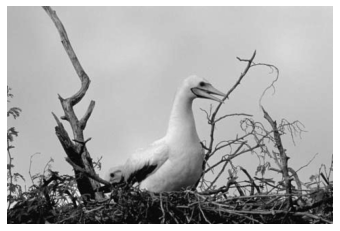

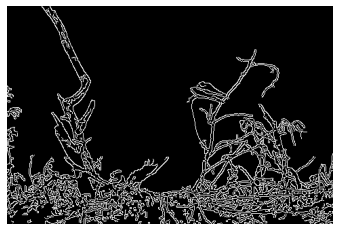

In [147]:
showgray(nimg)
showgray(nsparse)

In [148]:
out = mL(img/255, nsparse);

d
generating matting laplacian 1 / 319
generating matting laplacian 2 / 319
generating matting laplacian 3 / 319
generating matting laplacian 4 / 319
generating matting laplacian 5 / 319
generating matting laplacian 6 / 319
generating matting laplacian 7 / 319
generating matting laplacian 8 / 319
generating matting laplacian 9 / 319
generating matting laplacian 10 / 319
generating matting laplacian 11 / 319
generating matting laplacian 12 / 319
generating matting laplacian 13 / 319
generating matting laplacian 14 / 319
generating matting laplacian 15 / 319
generating matting laplacian 16 / 319
generating matting laplacian 17 / 319
generating matting laplacian 18 / 319
generating matting laplacian 19 / 319
generating matting laplacian 20 / 319
generating matting laplacian 21 / 319
generating matting laplacian 22 / 319
generating matting laplacian 23 / 319
generating matting laplacian 24 / 319
generating matting laplacian 25 / 319
generating matting laplacian 26 / 319
generating matting 

generating matting laplacian 214 / 319
generating matting laplacian 215 / 319
generating matting laplacian 216 / 319
generating matting laplacian 217 / 319
generating matting laplacian 218 / 319
generating matting laplacian 219 / 319
generating matting laplacian 220 / 319
generating matting laplacian 221 / 319
generating matting laplacian 222 / 319
generating matting laplacian 223 / 319
generating matting laplacian 224 / 319
generating matting laplacian 225 / 319
generating matting laplacian 226 / 319
generating matting laplacian 227 / 319
generating matting laplacian 228 / 319
generating matting laplacian 229 / 319
generating matting laplacian 230 / 319
generating matting laplacian 231 / 319
generating matting laplacian 232 / 319
generating matting laplacian 233 / 319
generating matting laplacian 234 / 319
generating matting laplacian 235 / 319
generating matting laplacian 236 / 319
generating matting laplacian 237 / 319
generating matting laplacian 238 / 319
generating matting laplac

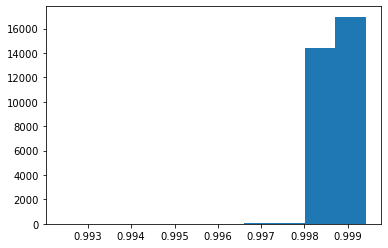

In [107]:
plt.hist(out.flat);

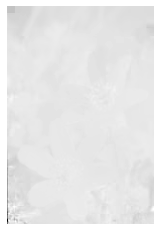

In [108]:
showgray(out)

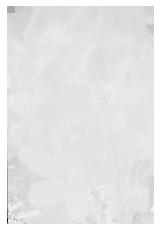

In [105]:
showgray(out)

(array([ 31150.,  30447., 106380., 148722., 126056.,  84966.,  65730.,
         73295.,  87408.,  32278.]),
 array([  3. ,  28.2,  53.4,  78.6, 103.8, 129. , 154.2, 179.4, 204.6,
        229.8, 255. ]),
 <BarContainer object of 10 artists>)

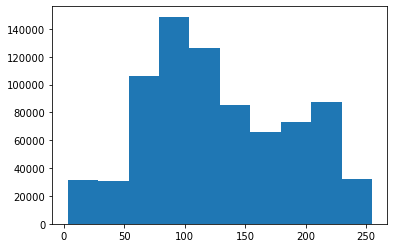

In [324]:
plt.hist(img.flat)